# CompBayes: Report04

## Uma Desai

MIT License: https://opensource.org/licenses/MIT

In [344]:
from __future__ import print_function, division

% matplotlib inline
import warnings
warnings.filterwarnings('ignore')

import thinkbayes2
import math
import numpy as np
import scipy.stats as stats
from scipy.stats import norm
from scipy.special import gamma
from itertools import product
from thinkbayes2 import Pmf, Cdf, Suite, Joint, Beta, MakeExponentialPmf, EvalExponentialCdf, EvalGammaPdf, MakeGammaPmf, EvalPoissonPmf, MakePoissonPmf, MakeMixture 

import thinkplot
import pandas as pd

## #1. Are you from Oakland?: Type I (Discrete Hypothesis)

You're walking into West Hall when you see a fellow Oliner watching a pre-season NBA game and chearing loudly for the Golden State Warriors, your home team. You're very excited at the prospect of meeting another Oliner from Oakland. But what are the chances that this person is really from your home town?

To solve this problem, you need to first make some assumptions about the situation. We can estimate that there is about a 1 in 35 chance that a random Oliner is from Oakland, California or in the nearby Bay Area, based on our current student population. We can also estimate that, considering the success of the Warriors, there is a 95% chance that anyone from somewhere in Oakland or the Bay Area is a fan of the Warriors. Finally, we need to estimate the chance that a random person from Olin turns out to be a fan of the Warriors. Normally there is a very low chance that the average Oliner is a fan of a random NBA team, but since there has been so much hype surrounding the Warriors in the past few NBA championships, this estimation is extremely skewed, so we'll say there's a 30% chance that an Oliner can claim to be a Warriors fan. 

Taking into consideration all of these assumptions, we can use Bayes' theorem to estimate the chance that the person you saw cheering for the Warriors in the West Hall lounge is actually from Oakland. 

In [345]:
pmf = Pmf()
pmf.Set('From Oakland', 1/35)
pmf.Set('Not from Oakland', 34/35)

like1 = 0.95
like2 = 0.3

pmf.Mult('From Oakland', like1)
pmf.Mult('Not from Oakland', like2)

pmf.Normalize()

pmf.Print()

From Oakland 0.085201793722
Not from Oakland 0.914798206278


So, unfortunately for you, the chance that you've actually found a fellow Oliner who's from your hometown is very unlikely, around 8.52%. If only your home team wasn't so good.

## #2. Helium Footballs: Type III (Multiple Dimensions)
From: http://lib.stat.cmu.edu/DASL/Stories/Heliumfootball.html

> Two identical footballs, one air-filled and one helium-filled, were used outdoors on a windless day at The Ohio State University's athletic complex. The kicker was a novice punter and was not informed which football contained the helium. Each football was kicked 39 times. The kicker changed footballs after each kick so that his leg would play no favorites if he tired or improved with practice. The line plot of the total distance for each trial has an initial upward trend and then appears to level off, suggesting that the kicker improved with practice. We can also see the presence of possible outliers which may be the result of flubbed kicks. Boxplots of trials 1-20 and 21-39 indicate an improvement in the average distance and a smaller standard deviation for the second 19 kicks. We can also see the presence of two trials in which there are possible flubbed kicks. Based on summary statistics, Lafferty (1993) asserts there is "not much difference" in the results for the two footballs.

Do you agree with Lafferty's conclusion? What is the probability, based on this data, that the football filled with helium travels farther when kicked than the football filled with air? If there is a difference, can we translate this difference into a most likely average advantage that a team might have (in yards) if they were to punt a football filled with helium instead of air?

In [282]:
df = pd.read_csv('Football.csv', skiprows=0, index_col = 'Trial')
df.head(7)

,Air,Helium
Trial,,
1,25,25
2,23,26
3,18,25
4,16,14
5,35,23
6,25,29
7,26,25


In [283]:
air_distances = np.array(df['Air'])
helium_distances = np.array(df['Helium'])
air_mean = air_distances.mean()
helium_mean = helium_distances.mean()
print (air_mean, helium_mean)

26.3333333333 27.0769230769


The means of the data show a 0.75 higher average distance reached by the helium footballs. This number is a relatively small difference, and we want to be more confident in determining whether the two footballs actually produce different results. We will use a Bayesian approach, similar to the one used by Allen Downey to solve the Improve Reading Ability problem from the Chapter 9 workbook, to estimate the probability that the helium football travels farther.

In [257]:
class Normal(Suite, Joint):
    
    def Likelihood(self, data, hypo):
        """
        Determines the likelihood, based on the distances reached by each football,
        of a mu and sigma combination.
        
        hypo: mu, sigma
        data: distances recorded for each football
        outputs: likelihood of hypo from a normal distribution
        """
        mu, sigma = hypo
        likes = norm.pdf(data, mu, sigma)
        return np.prod(likes)

Set the range for possible values of mu and sigma.

In [246]:
prior_mus = np.linspace(22, 31, 101)
prior_sigmas = np.linspace(1, 9, 101)

Creat a class instance of Normal called air, enumerate all possible combinations of mu and sigma, and update with data from the air-filled football.

In [258]:
air = Normal(product(prior_mus, prior_sigmas))
air.Update(air_distances)

1.899493383340065e-50

Plot the joint distribution of likely mu and sigma values for the air-filled footballs.

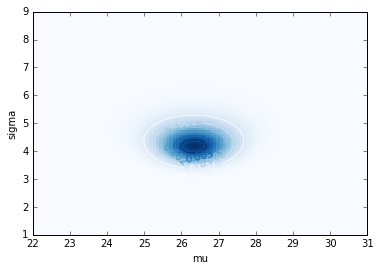

In [248]:
thinkplot.Contour(air, pcolor=True)
thinkplot.Config(xlabel='mu', ylabel='sigma')

Plot the marginal distribution of mu to show the distribution of possible mean distances travelled by the air-filled football.

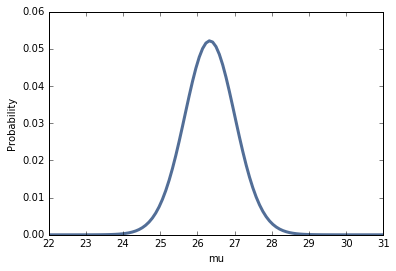

In [284]:
air_mu = air.Marginal(0)
thinkplot.Pdf(air_mu)
thinkplot.Config(xlabel='mu', ylabel='Probability')

Creat a class instance of Normal called helium, enumerate all possible combinations of mu and sigma, and update with data from the air-filled football.

In [259]:
helium = Normal(product(prior_mus, prior_sigmas))
helium.Update(helium_distances)

1.1442551346763492e-54

Plot the joint distribution of likely mu and sigma values for the helium-filled footballs.

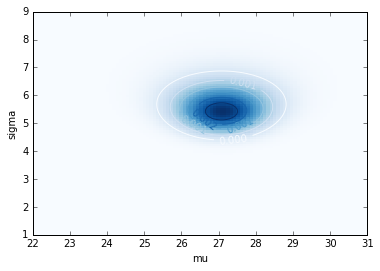

In [252]:
thinkplot.Contour(helium, pcolor=True)
thinkplot.Config(xlabel='mu', ylabel='sigma')

Plot the marginal distribution of mu to show the distribution of possible mean distances travelled by the helium-filled football.

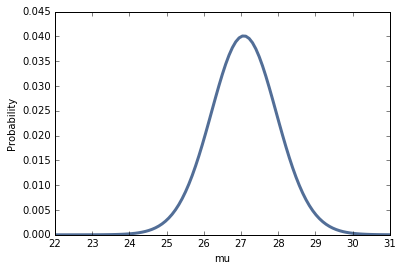

In [285]:
helium_mu = helium.Marginal(0)
thinkplot.Pdf(helium_mu)
thinkplot.Config(xlabel='mu', ylabel='Probability')

To see the probability that the two footballs actually produce different results, we can subtract the marginal distributions of mu for each football and determine the probability that this defference is greater than 0.

0.74344151129541103

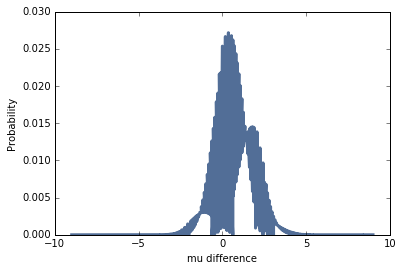

In [292]:
mu_difference = helium_mu - air_mu
thinkplot.Pdf(mu_difference)
thinkplot.Config(xlabel='mu difference', ylabel='Probability')
mu_difference.Mean()

0.72976195617455941

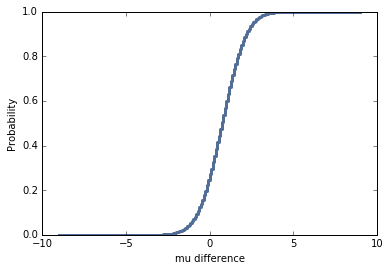

In [287]:
thinkplot.Cdf(mu_difference.MakeCdf())
thinkplot.Config(xlabel='mu difference', ylabel='Probability')
1 - mu_difference.MakeCdf()[0]

So it is definitely possible, based on this data, that Lafferty was wrong and that the two footballs are in fact not the same; there is an estimated 73% chance that kicking a helium-filled football will travel farther than kicking an air-filled football.

In [281]:
mu_difference.Mean()

0.74344151129541103

According to the data, the likely average advantage that a team might have if they were to punt a football filled with helium instead of air is 0.743 yards.

Is there a signficant variance in the data? Is there a noticeable difference in variance between the results from each football?

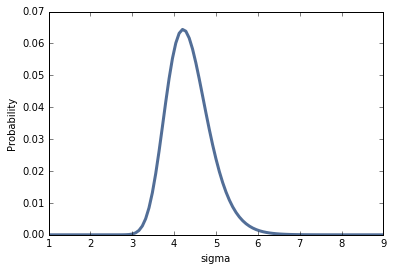

In [289]:
air_sigma = air.Marginal(1)
thinkplot.Pdf(air_sigma)
thinkplot.Config(xlabel='sigma', ylabel='Probability')

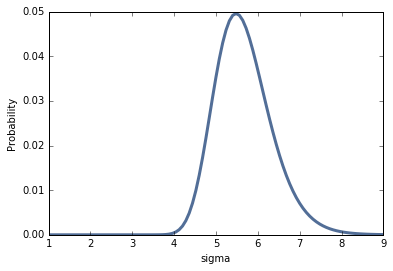

In [290]:
helium_sigma = helium.Marginal(1)
thinkplot.Pdf(helium_sigma)
thinkplot.Config(xlabel='sigma', ylabel='Probability')

1.3083764308670183

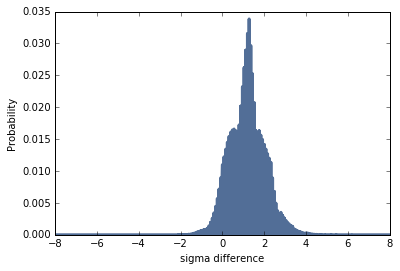

In [291]:
sigma_difference = helium_sigma - air_sigma
thinkplot.Pdf(sigma_difference)
thinkplot.Config(xlabel='sigma difference', ylabel='Probability')
sigma_difference.Mean()

0.93703729872693453

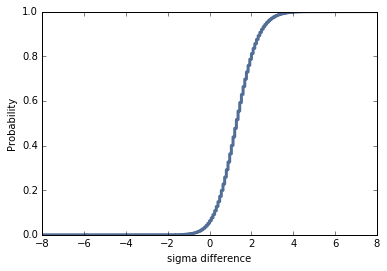

In [288]:
thinkplot.Cdf(sigma_difference.MakeCdf())
thinkplot.Config(xlabel='sigma difference', ylabel='Probability')
1 - sigma_difference.MakeCdf()[0]

Our results show us that there is notable variance in the data, likely due to flubbed kicks during data collection, which could explain why Lafferty questioned that there was an actual difference between the two footballs. There also appears to be significantly more variance in the data from the helium football than from the air football. There are many reasons why this might be, but it is possible that, since helium is actually lighter than air, the ball may be more easily disrupted in flight due to wind or other factors.

## #3. Vancouver Canucks
#### These warm up exercises are from Allen Downey's Chapter 7 workbook.

**Exercise:** Suppose that goal scoring in hockey is well modeled by a 
Poisson process, and that the long-run goal-scoring rate of the
Boston Bruins against the Vancouver Canucks is 2.9 goals per game.
In their next game, what is the probability
that the Bruins score exactly 3 goals?  Plot the PMF of `k`, the number
of goals they score in a game.

0.223660236699


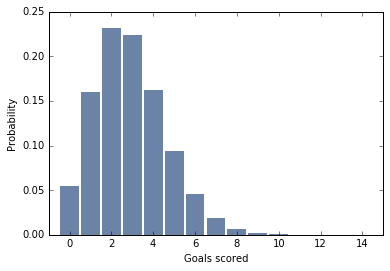

In [26]:
from thinkbayes2 import MakePoissonPmf

pmf = MakePoissonPmf(2.9, 15)
thinkplot.hist(pmf)
thinkplot.Config(xlabel='Goals scored',
                 ylabel='Probability',
                 xlim=[-1, 15])
probability = pmf[3]
print (probability)

**Exercise:**  Assuming again that the goal scoring rate is 2.9, what is the probability of scoring a total of 9 goals in three games?  Answer this question two ways:

1.  Compute the distribution of goals scored in one game and then add it to itself twice to find the distribution of goals scored in 3 games.

2.  Use the Poisson PMF with parameter $\lambda t$, where $\lambda$ is the rate in goals per game and $t$ is the duration in games.

0.131083566213


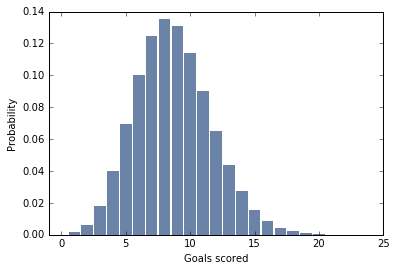

In [25]:
game = MakePoissonPmf(2.9, 50)
all_games = game + game + game
thinkplot.hist(all_games)
thinkplot.Config(xlabel='Goals scored',
                 ylabel='Probability',
                 xlim=[-1, 25])

probability = all_games[9]
print(probability)

In [28]:
lam = 2.9
t = 3
EvalPoissonPmf(9, lam*t)

0.13108356621294354

**Exercise:** Suppose that the long-run goal-scoring rate of the
Canucks against the Bruins is 2.6 goals per game.  Plot the distribution
of `t`, the time until the Canucks score their first goal.
In their next game, what is the probability that the Canucks score
during the first period (that is, the first third of the game)?

Hint: `thinkbayes2` provides `MakeExponentialPmf` and `EvalExponentialCdf`.

0.5796496154913181

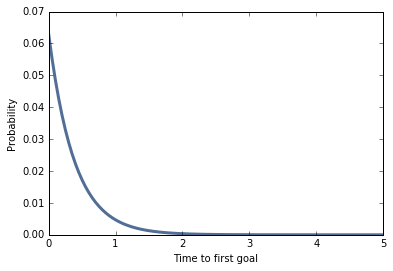

In [46]:
t = MakeExponentialPmf(2.6, 5)
thinkplot.Pdf(t)
thinkplot.Config(xlabel='Time to first goal',
                 ylabel='Probability')
EvalExponentialCdf(1/3, 2.6)

**Exercise:** Assuming again that the goal scoring rate is 2.8, what is the probability that the Canucks get shut out (that is, don't score for an entire game)?  Answer this question two ways, using the CDF of the exponential distribution and the PMF of the Poisson distribution.

In [50]:
1 - EvalExponentialCdf(1, 2.8)

0.06081006262521793

In [51]:
EvalPoissonPmf(0, 2.8)

0.060810062625217973

### #4. World Cup Problem
#### This btp from Allen Downey's Chapter 7 workbook and includes several functions form thinkbayes2.py.

**Exercise:** In the 2014 FIFA World Cup, Germany played Brazil in a semifinal match. Germany scored after 11 minutes and again at the 23 minute mark. At that point in the match, how many goals would you expect Germany to score after 90 minutes? What was the probability that they would score 5 more goals (as, in fact, they did)?

Note: for this one you will need a new suite that provides a Likelihood function that takes as data the time between goals, rather than the number of goals in a game.

To solve this question, we will make the assumption that scoring goals can be modeled by a Poisson distribution where events are equally likely to occur at any time, and that the time between each goal has an exponential distribution.

We first need to estimate lambda, the number of goals that Germany will score in 90 minutes, using the data from the first two goals and an informed prior. A great representation for the prior for this case is a gamma distribution that uses average goals scored by each team per game in the previous world cup held in South Africa in 2010 (2.23) as the mean of the distribution.

2.2239841087283128

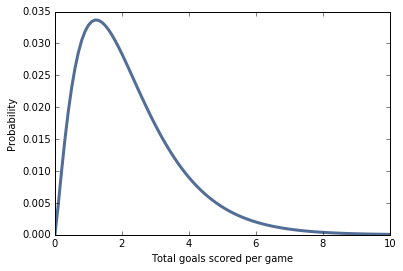

In [338]:
prior = MakeGammaPmf(np.linspace (0, 10, 101), 2.23)
thinkplot.Pdf(prior)
thinkplot.Config(xlabel='Total goals scored per game', ylabel = 'Probability')
prior.Mean()

In [339]:
class Goals(Suite):
    """Estimates lambda (rate at which Germany scores goals per game)
    using data of the time before each of the first two goals scored."""

    def Likelihood(self, data, hypo):
        """
        hypo: lambda
        data: time between scored goals with respect to game duration
        """
        like = hypo * math.exp(-hypo * data/90)    # 90 minutes in the game
        return like

Next we instantiate a Goals suite called game that takes in the Gamma distribution as our prior.

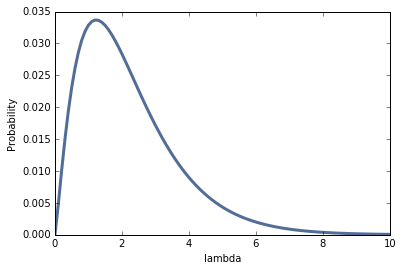

In [340]:
game = Goals(prior)
thinkplot.Config(xlabel='lambda', ylabel = 'Probability')
thinkplot.Pdf(game)

Update our suite with data from the first two goals. The first goal was 11 minutes in, and the second goal 12 minutes later.

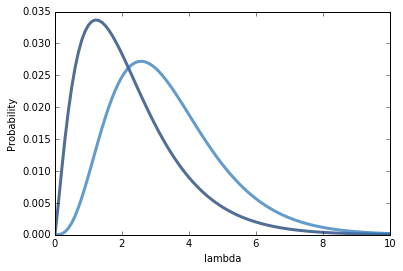

In [341]:
thinkplot.Pdf(game)
game.Update(11)
game.Update(12)
thinkplot.Config(xlabel='lambda', ylabel = 'Probability')
thinkplot.Pdf(game)

This shows the distribution of Germany's goal scoring rate in a game based off the data from the first two goals. Our mean lambda value is 2.6 goals/game. Now that we have estimated a distribution for lambda, we need to predict the number of goals that Germany will score in the remainder of the game. This would be really easy if we had one value for lambda but because we don't know the exact value for lambda, this problem becomes a mixture.

To get the mixture, we must enumerate all possible values of lambda and evaluate a poisson distribution for each possible lambda value, then weight them based on how likely each is, and finally add them up.

2.4967596544837072

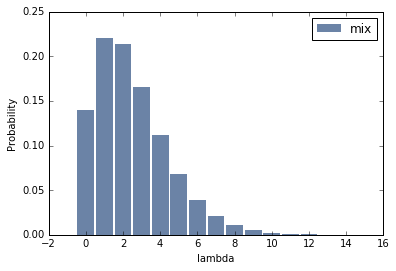

In [342]:
mixture = Pmf()
for hypo, weight in game.Items():
    x = MakePoissonPmf(hypo * 67 / 90, 15)
    mixture[x] = weight
mixture_prediction = MakeMixture(mixture)
thinkplot.hist(mixture_prediction)
thinkplot.Config(xlabel='lambda', ylabel = 'Probability')
mixture_prediction.Mean()

In [343]:
mixture_prediction.Prob(5)

0.068112015099822301

So, to answer the original question, at this point in the match (after 2 goals scored), I would expect Germany to score about 2 more goals before the end of the game, and I would estimate the probability that they would score 5 more goals to be around 6.81%.